<a href="https://colab.research.google.com/github/danghoangminh/CS338.L21.KHCL/blob/main/Alexnet%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

dataset_path = "/content/drive/MyDrive/Colab Notebooks/Recognition/Lab 1/dogs-vs-cats/"

with zipfile.ZipFile(dataset_path + "train.zip","r") as z:
    z.extractall("./dogs-vs-cats/")
    
with zipfile.ZipFile(dataset_path + "test1.zip","r") as z:
    z.extractall("./dogs-vs-cats/")

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torchvision import models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

DIR_TRAIN = "/content/dogs-vs-cats/train/"
DIR_TEST = "/content/dogs-vs-cats/test1/"

In [ ]:
### Load list image
imgs = os.listdir(DIR_TRAIN)
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['cat.465.jpg', 'cat.5925.jpg', 'cat.9336.jpg', 'dog.11781.jpg', 'cat.9538.jpg']
['540.jpg', '8898.jpg', '2038.jpg', '673.jpg', '4225.jpg']


In [ ]:
### Class Distribution
class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

In [ ]:
### List image each class
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

In [ ]:
### Pick random 100 image from each class
imgs = random.sample(dogs_list, 100) + random.sample(cats_list, 100)
random.shuffle(imgs)

In [ ]:
### Get list labels of images train
labels = [class_to_int[img.split(".")[0]] for img in imgs]
print("Total image:", len(labels))

Total image: 200


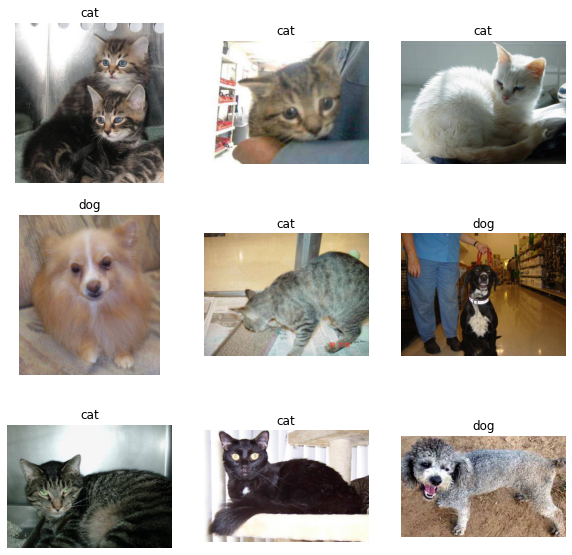

In [ ]:
### Visualize Random Images from Train set
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, 1 + i)
  img = random.choice(imgs)
  label = int_to_class[labels[imgs.index(img)]]
  img = plt.imread(DIR_TRAIN + img)
  plt.axis('off')
  plt.title(label)
  plt.imshow(img)
plt.show()

In [ ]:
### Check GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
### Load the pre-trained model
model = models.alexnet(pretrained=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		### Extract Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		### Extract Average Pooling Layer
    self.pooling = model.avgpool
		### Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		### Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		### It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 

In [ ]:
### Initialize the model
new_model = FeatureExtractor(model)

### Send model to device
new_model = new_model.to(device)

print(new_model)

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pooling): AdaptiveAvgPool2d(output_size=(6, 6))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Dropout(p=0.5, inplace=False)
)


In [ ]:
### Transform the image, so it becomes readable with the model
transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.CenterCrop(512),
      transforms.Resize(448),
      transforms.ToTensor()                              
])

In [ ]:
### Will contain the feature
features = []
count = 0

for img in imgs:
  ### Read the file
  img = cv2.imread(DIR_TRAIN + img)

  ### Transform the image
  img = transform(img)

  ### Reshape the image. PyTorch model reads 4-dimensional tensor
	### [batch_size, channels, width, height]
  img = img.reshape(1, 3, 448, 448)

  ### Send image to device
  img = img.to(device)

  ### Extract the feature from the image
  with torch.no_grad():
    feature = new_model(img)

  ### Convert to NumPy Array, Reshape it, and save it to features variable
  features.append(feature.cpu().detach().numpy().reshape(-1))
  count += 1

  if count%50 == 0:
    print("Load", count, "image complete!")

Load 50 image complete!
Load 100 image complete!
Load 150 image complete!
Load 200 image complete!


In [ ]:
### Convert to NumPy Array
features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Label shape:", labels.shape)

Features shape: (200, 9216)
Label shape: (200,)


In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [ ]:
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred_linear = clf_linear.predict(X_test)
y_pred_rbf = clf_rbf.predict(X_test)
y_pred_poly = clf_poly.predict(X_test)

In [ ]:
print("Classification report for SVM with kernel linear:\n{}\n".format(metrics.classification_report(y_test, y_pred_linear)))

print("Classification report for SVM with kernel rbf:\n{}\n".format(metrics.classification_report(y_test, y_pred_rbf)))

print("Classification report for SVM with kernel poly:\n{}\n".format(metrics.classification_report(y_test, y_pred_poly)))

Classification report for SVM with kernel linear:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.89      0.81      0.85        21

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40


Classification report for SVM with kernel rbf:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        19
           1       0.70      0.76      0.73        21

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40


Classification report for SVM with kernel poly:
              precision    recall  f1-score   support

           0       1.00      0.37      0.54        19
           1       0.64      1.00      0.78        21

    accuracy                       